In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modules.minisom import MiniSom
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV


# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data
path = "C:\\Users\\Samsung\\OneDrive\\Ícaro Augusto\\Portfolio\\deeplearning_chemicalengineering\\0_data\\som_studies\\data_rotaA.csv"
data = pd.read_csv(path, index_col=[0])

In [3]:
# define the columns that will be used in the SOM
x_cols = ['x_glic_et', 'x_cell_glic', 'eta_cell_orgsolv', 'capex_f1_A',
          'raw_mat_price', 'enzyme_load', 'lign_price', 'et_price']

# define the targets column
target1 = 'msp'
target2 = 'vpl'

# sample x and ys
x = data[x_cols]
y1 = data[[target1]]
y2 = data[[target2]]

In [4]:
# scale the features and fit SOM
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x)

x_sc = scaler.transform(x)

# determine the grid size
N = int(np.sqrt(5 * np.sqrt(x_sc.shape[0]))) 
print(f'Map Size: {N}')

Map Size: 18


In [5]:
# save scaler
joblib.dump(scaler, '..\\1_models\\som_studies\\scaler_som.pkl')

['..\\1_models\\som_studies\\scaler_som.pkl']

In [6]:
# fit a SOM with the best influence radius (n=1)
som = MiniSom(x=N, y=N, input_len=x_sc.shape[1], sigma=1, learning_rate=0.5)
som.random_weights_init(x_sc)
som.train_random(x_sc, num_iteration=200)

In [7]:
# get the distance map
dists = som.distance_map()

In [8]:
# get winning neurons for each sample
dist_list = []
winning = []
for i in range(x_sc.shape[0]):

    # get winning neuron coordinates
    coord = som.winner(x=x_sc[i])
    winning.append(coord)

    # get distance
    dist_list.append(dists[coord])

# add the winning neurons to the data
x_data = pd.DataFrame(scaler.inverse_transform(x_sc), columns=x_cols)
x_data['winning'] = winning
x_data['dist'] = dist_list

# append the target column
x_data[target1] = y1
x_data[target2] = y2

In [9]:
# define the values of the targets for each target variable
target1_goal = 1.96
target2_goal = 700

In [10]:
# get the averages for each winning neuron that satisfies the goals
win_avg1 = x_data[x_data[target1] < target1_goal].groupby('winning')[target1].agg(['mean']).dropna().sort_values(by='mean')
win_avg2 = x_data[x_data[target2] > target2_goal].groupby('winning')[target2].agg(['mean']).dropna().sort_values(by='mean',
                                                                                                                 ascending=False)

In [11]:
# define how many winning neurons will be considered
LIMIT_WINNING_NEURONS = 150

# get lists of winning neurons that satisfy the goals
winning1 = win_avg1.index[:LIMIT_WINNING_NEURONS].tolist()
winning2 = win_avg2.index[:LIMIT_WINNING_NEURONS].tolist()

In [12]:
# select the data that are in winning neurons
data1 = x_data[x_data['winning'].isin(winning1)]
data2 = x_data[x_data['winning'].isin(winning2)]

display(data1)
display(data2)

,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,winning,dist,msp,vpl
0,0.976569,0.787937,0.889449,205.473492,70.663194,0.007727,903.385798,0.447326,"(3, 5)",0.533244,1.686078,540.485266
5,0.969146,0.757614,0.922314,202.945229,76.208792,0.011663,780.840700,0.632453,"(6, 3)",0.518334,1.672244,466.441457
7,0.950887,0.738502,0.870992,240.583989,70.615092,0.010209,977.255142,0.501975,"(7, 4)",0.461194,2.217521,637.275646
11,0.957827,0.713778,0.862236,229.663745,71.508500,0.009033,822.052759,0.554104,"(10, 1)",0.700422,2.301909,586.834662
12,0.963253,0.740773,0.930560,227.128127,67.343253,0.009521,940.010253,0.591233,"(1, 6)",0.602412,1.588317,527.379986
...,...,...,...,...,...,...,...,...,...,...,...,...
4991,0.961293,0.803340,0.898068,219.988511,70.194532,0.012299,803.789108,0.577512,"(3, 11)",0.532124,1.769917,519.328619
4993,0.961060,0.745850,0.913627,252.620066,74.404440,0.008795,999.650277,0.562460,"(10, 17)",0.363338,1.973034,623.179928
4995,0.949436,0.770151,0.885624,234.692710,67.313712,0.013022,893.184482,0.610056,"(8, 2)",0.482614,1.877851,554.626735
4996,0.936758,0.657297,0.967616,184.192279,58.552768,0.009603,808.310328,0.514659,"(12, 17)",0.454421,1.630479,457.178209


,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,winning,dist,msp,vpl
1,0.956862,0.697031,0.870200,256.145825,76.640585,0.010395,893.923770,0.446495,"(11, 12)",0.544816,2.996498,729.562968
2,0.964778,0.806197,0.803527,202.344370,78.310554,0.017116,767.302721,0.481609,"(14, 5)",0.591325,2.538382,595.792014
3,0.943717,0.770093,0.904887,297.564872,72.026417,0.008907,838.764176,0.500520,"(8, 12)",0.430043,2.767356,764.403397
4,0.919226,0.809285,0.922147,252.531233,67.256069,0.010384,757.452794,0.554279,"(6, 17)",0.333393,2.132031,605.795255
6,0.941724,0.837683,0.874975,289.721577,80.250627,0.007769,672.530280,0.486988,"(9, 4)",0.619852,2.894345,755.021276
...,...,...,...,...,...,...,...,...,...,...,...,...
4989,0.958094,0.790618,0.912135,271.840365,73.712362,0.008157,929.651707,0.469422,"(2, 5)",0.518348,2.288968,704.527931
4992,0.932744,0.697561,0.935692,240.589326,75.112614,0.010183,805.499626,0.502469,"(11, 3)",0.598849,2.635973,653.028220
4993,0.961060,0.745850,0.913627,252.620066,74.404440,0.008795,999.650277,0.562460,"(10, 17)",0.363338,1.973034,623.179928
4998,0.924641,0.782286,0.889613,268.826667,63.847676,0.009209,764.224502,0.507320,"(6, 17)",0.333393,2.479401,669.396759


In [13]:
# drop unused columns from the data
data1.drop(columns=['winning', 'dist', target2], inplace=True)
data2.drop(columns=['winning', 'dist', target1], inplace=True)

## Modeling of Minimum Selling Price - MSP

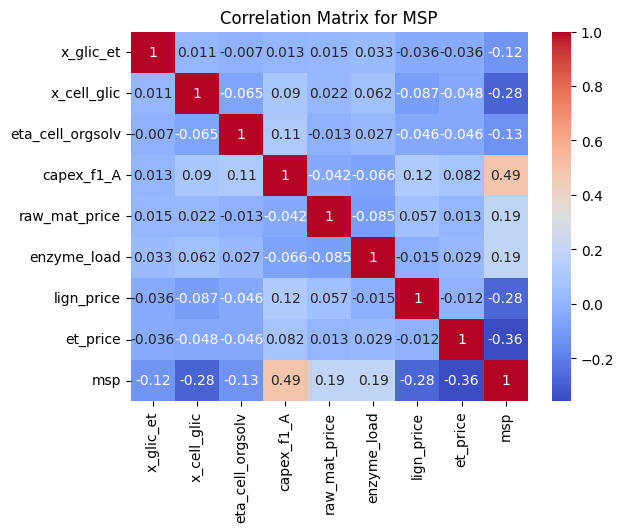

In [14]:
# let's check the data correlation
sns.heatmap(data1.corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for MSP')
plt.show()

- the correlations are not linear. The strongest correlations with the target 1 is the value of CAPEX from phase 1, and the Ethanol selling price.

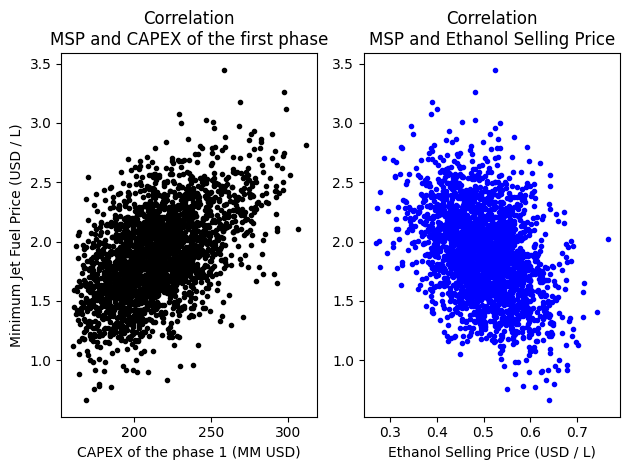

In [15]:
plt.subplot(121)                                                    
plt.scatter(data1['capex_f1_A'], data1['msp'], marker='.', color='k')                  
plt.xlabel('CAPEX of the phase 1 (MM USD)')  
plt.ylabel('Minimum Jet Fuel Price (USD / L)')
plt.title('Correlation\nMSP and CAPEX of the first phase')

plt.subplot(122)
plt.scatter(data1['et_price'], data1['msp'], marker='.', color='b')
plt.xlabel('Ethanol Selling Price (USD / L)')
plt.title('Correlation\nMSP and Ethanol Selling Price')

plt.tight_layout()
plt.show()

In [16]:
# define a function for modeling the data
def model_data(data: pd.DataFrame, target: str, model_alias: str) -> object:
    """
    fits and selects the best model for the data

    Parameters
    ----------
    data : pd.DataFrame
        data to be modeled
    target : str
        target variable name
    model_alias : str
        alias for the model

    Returns
    -------
    object
        fitted model
    """
    # select x and y
    x = data.drop(columns=[target])
    y = data[target]

    print(x.describe())

    # configure the cross validation
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    # split train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # configure the dictionary with the pipelines and hyperparameters
    models = {
        'lr':{
            'model': Pipeline([
                ('selector', SelectKBest(f_regression)),
                ('scaler', RobustScaler()),
                ('lr', LinearRegression())
            ]),
            'params': {
                'selector__k': range(1, ((x.shape[1]) // 2) + 1),
            }
        },
        'rf':{
            'model': Pipeline([
                ('selector', SelectKBest(f_regression)),
                ('scaler', RobustScaler()),
                ('rf', RandomForestRegressor())
            ]),
            'params': {
                'selector__k': range(1, ((x.shape[1]) // 2) + 1),
                'rf__n_estimators': range(100, 1001, 100),
                'rf__max_depth': range(1, 11)
            }
        },
        'gb':{
            'model': Pipeline([
                ('selector', SelectKBest(f_regression)),
                ('scaler', RobustScaler()),
                ('gb', GradientBoostingRegressor())
            ]),
            'params': {
                'selector__k': range(1, ((x.shape[1]) // 2) + 1),
                'gb__n_estimators': range(100, 1001, 100),
                'gb__max_depth': range(1, 11)
            }
        }
    }

    # configure the RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=models[model_alias]['model'],
        param_distributions=models[model_alias]['params'],
        n_iter=100,
        scoring='r2',
        n_jobs=-1,
        cv=cv,
        random_state=42,
        refit=True,
        verbose=10
    )

    # fit the model
    search.fit(x_train, y_train)

    # get the best model
    model = search.best_estimator_

    # print training and test report
    print(f'{model_alias.upper()}')
    print(f'Best Parameters: {search.best_params_}')
    print(f'Best Score: {search.best_score_}')
    print(f'Training R2: {model.score(x_train, y_train)}')
    print(f'Test R2: {model.score(x_test, y_test)}')
    print(f'Training MAE: {round(mean_absolute_error(y_train, model.predict(x_train)), 2)}')
    print(f'Test MAE: {round(mean_absolute_error(y_test, model.predict(x_test)), 2)}')
    print(f'Training RMSE: {round(mean_squared_error(y_train, model.predict(x_train), squared=False), 2)}')
    print(f'Test RMSE: {round(mean_squared_error(y_test, model.predict(x_test), squared=False), 2)}')
    print('\n')

    return model



In [17]:
# model data for MSP
model_dict1 = {}
for model in ['lr', 'rf', 'gb']:
    model_dict1[model] = model_data(data1, target1, model)

         x_glic_et  x_cell_glic  eta_cell_orgsolv   capex_f1_A  raw_mat_price  \
count  2393.000000  2393.000000       2393.000000  2393.000000    2393.000000   
mean      0.951254     0.786128          0.908372   215.495734      68.492101   
std       0.020558     0.049543          0.040076    27.062847       5.564331   
min       0.902010     0.656431          0.801030   160.017481      55.958510   
25%       0.936279     0.751482          0.879634   195.768504      64.487364   
50%       0.951166     0.786997          0.908611   213.046670      68.575086   
75%       0.966262     0.822927          0.938677   232.490056      72.567065   
max       0.998776     0.896378          0.995663   311.788058      82.955301   

       enzyme_load   lign_price     et_price  
count  2393.000000  2393.000000  2393.000000  
mean      0.011419   835.599914     0.499095  
std       0.002851   117.555172     0.071483  
min       0.006001   526.811752     0.270158  
25%       0.009277   751.591598    

## Modeling of Net Present Value

In [18]:
# model data for VPL
model_dict2 = {}
for model in ['lr', 'rf', 'gb']:
    model_dict2[model] = model_data(data2, target2, model)

         x_glic_et  x_cell_glic  eta_cell_orgsolv   capex_f1_A  raw_mat_price  \
count  2282.000000  2282.000000       2282.000000  2282.000000    2282.000000   
mean      0.948885     0.770177          0.900053   253.365305      69.815205   
std       0.021000     0.051365          0.040844    28.730862       5.685853   
min       0.902211     0.650711          0.803068   168.708794      56.151408   
25%       0.932797     0.732097          0.870773   233.531412      65.610500   
50%       0.948963     0.769618          0.899819   253.990303      69.806019   
75%       0.964357     0.805533          0.930197   274.864639      73.986003   
max       0.998894     0.896261          0.997024   318.215820      82.528202   

       enzyme_load   lign_price     et_price  
count  2282.000000  2282.000000  2282.000000  
mean      0.012390   801.867334     0.475381  
std       0.003033   118.829773     0.073275  
min       0.006001   529.295907     0.222289  
25%       0.010097   716.384157    

In [19]:
# save both lr models in the folder
joblib.dump(model_dict1['lr'], '..\\1_models\\som_studies\\model_msp.pkl')
joblib.dump(model_dict2['lr'], '..\\1_models\\som_studies\\model_vpl.pkl')

['..\\1_models\\som_studies\\model_vpl.pkl']

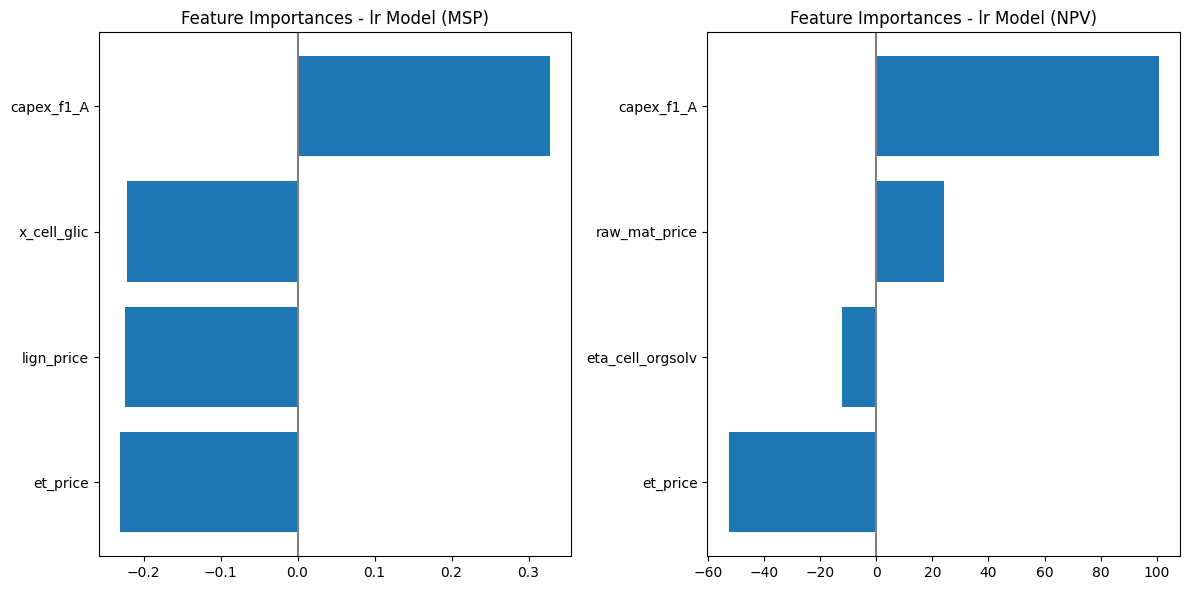

In [20]:

# Get the feature importances for lr model fitted using data1
lr_model1 = model_dict1['lr']
feature_importances1 = lr_model1.named_steps['lr'].coef_

# Get the feature importances for lr model fitted using data2
lr_model2 = model_dict2['lr']
feature_importances2 = lr_model2.named_steps['lr'].coef_

# Get the feature names
feature_selected1 = lr_model1.named_steps['selector'].get_support()
feature_selected2 = lr_model2.named_steps['selector'].get_support()

feature_names1 = data1.drop(columns=[target1]).columns[feature_selected1]
feature_names2 = data2.drop(columns=[target2]).columns[feature_selected2]

# For feature importances from graph 1
importances1 = zip(feature_names1, feature_importances1)
importances1 = sorted(importances1, key=lambda x: x[1])

# For feature importances from graph 2
importances2 = zip(feature_names2, feature_importances2)
importances2 = sorted(importances2, key=lambda x: x[1])

# get the feature importances and names
feature_names1 = [f[0] for f in importances1]
feature_importances1 = [f[1] for f in importances1]
feature_names2 = [f[0] for f in importances2]
feature_importances2 = [f[1] for f in importances2]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the feature importances for lr model fitted using data1
ax1.barh(feature_names1, feature_importances1)
ax1.set_title('Feature Importances - lr Model (MSP)')
ax1.axvline(x=0, color='.5')

# Plot the feature importances for lr model fitted using data2
ax2.barh(feature_names2, feature_importances2)
ax2.set_title('Feature Importances - lr Model (NPV)')
ax2.axvline(x=0, color='.5')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()